In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [7]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.h2o(hidden)
        return output, hidden

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.RNN_layers = nn.ModuleList([RNNCell(input_size, hidden_size) for _ in range(n_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.size(0))
        outputs = []
        for layer_idx in range(self.n_layers):
            layer_outputs = []
            for input_idx in range(input.size(1)):
                x = input[:, input_idx, :]
                output, hidden[layer_idx] = self.RNN_layers[layer_idx](x, hidden[layer_idx])
                layer_outputs.append(output)
            outputs.append(torch.stack(layer_outputs, dim=1))
            input = outputs[-1]
        output = self.fc(outputs[-1][:, -1, :])
        return output

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]


In [8]:
class LanguageDataset(Dataset):
    def __init__(self, min_length, max_length, p, num_samples):
        self.min_length = min_length
        self.max_length = max_length
        self.p = p
        self.num_samples = num_samples
        self.samples = self.generate_samples()
    
    def generate_samples(self):
        samples = []
        for _ in range(self.num_samples):
            length = np.random.randint(self.min_length, self.max_length + 1)
            if np.random.rand() < self.p:
                n = length // 3
                sequence = 'a' * n + 'b' * n + 'c' * n
            else:
                # Generate an invalid sequence
                sequence = self.generate_invalid_sequence(length)
            samples.append((sequence, int(self.is_language(sequence))))
        return samples
    
    def generate_invalid_sequence(self, length):
        sequence = ''.join(np.random.choice(['a', 'b', 'c'], size=length))
        while self.is_language(sequence):
            sequence = ''.join(np.random.choice(['a', 'b', 'c'], size=length))
        return sequence
    
    def is_language(self, sequence):
        counts = {'a': 0, 'b': 0, 'c': 0}
        for char in sequence:
            counts[char] += 1
        return counts['a'] == counts['b'] == counts['c']
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sequence, label = self.samples[idx]
        indices = torch.tensor([ord(c) - ord('a') for c in sequence], dtype=torch.long)
        one_hot_sequence = torch.nn.functional.one_hot(indices, num_classes=3).float()
        return one_hot_sequence, torch.tensor(label)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels




In [ ]:
def generate_data(min_length, max_length, p, num_samples, batch_size=32):
    dataset = LanguageDataset(min_length, max_length, p, num_samples)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return data_loader

# After generating the data loader, split it into train, validation, and test sets
data_loader = generate_data(21, 100, 0.5, 1000, 32)
train_size = int(0.7 * len(data_loader.dataset))
val_size = int(0.15 * len(data_loader.dataset))
test_size = len(data_loader.dataset) - train_size - val_size
train_data, val_data, test_data = random_split(data_loader.dataset, [train_size, val_size, test_size])

# Create separate data loaders for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Now train_loader, val_loader, and test_loader can be used for training, validation, and testing respectively


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0
    best_model = None
    for epoch in range(num_epochs):
        model.train()
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            hidden = model.init_hidden(sequences.size(0))
            outputs = model(sequences, hidden)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                hidden = model.init_hidden(sequences.size(0))
                outputs = model(sequences, hidden)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
    return best_model, best_val_acc

# Hyper-parameter search
input_size = 3  # 'a', 'b', 'c'
output_size = 2  # 0 or 1
hidden_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]
best_val_acc = 0
best_model = None

train_loader, val_loader, test_loader = generate_data(1, 20, 0.5, 1000, 32)

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        model = RNN(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        model, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model

print(f'Best validation accuracy: {best_val_acc}')


Best validation accuracy: 0.9466666666666667


Average length of the test sequences: 97.69333333333333


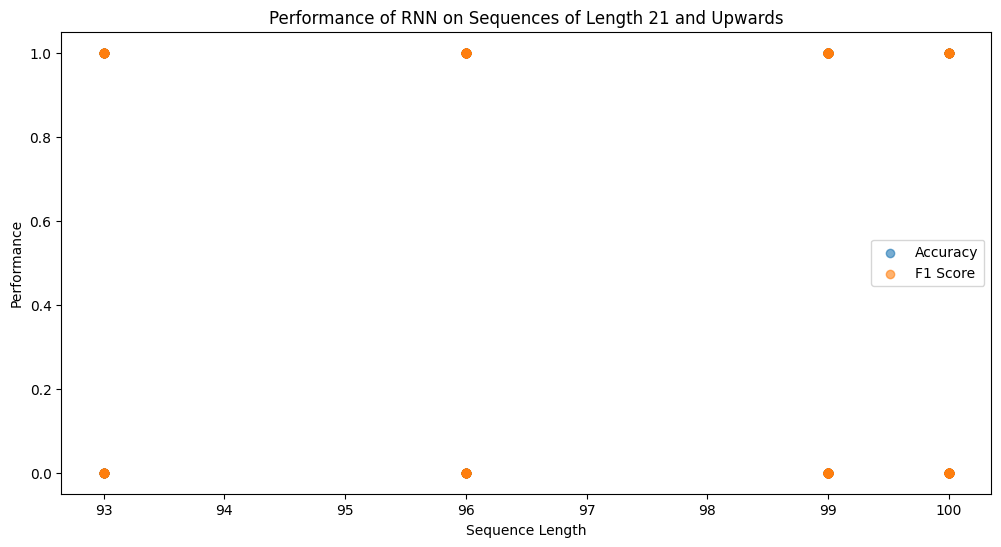

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Generate test set for sequences of length 21 to 100
_, _, test_loader = generate_data(21, 100, 0.5, 1000, 32)

# Initialize performance lists
lengths = []
accuracies = []
f1_scores = []

# Evaluate the best model on the new test set
best_model.eval()
with torch.no_grad():
    for sequences, labels in test_loader:
        batch_lengths = [seq.shape[0] for seq in sequences]
        hidden = best_model.init_hidden(sequences.size(0))
        outputs = best_model(sequences, hidden)
        _, predicted = torch.max(outputs.data, 1)
        
        for length, true_label, pred_label in zip(batch_lengths, labels, predicted):
            acc = accuracy_score([true_label.item()], [pred_label.item()])
            f1 = f1_score([true_label.item()], [pred_label.item()], zero_division=1)
            
            lengths.append(length)
            accuracies.append(acc)
            f1_scores.append(f1)

# Calculate average length of test sequences
average_length = np.mean(lengths)
print(f'Average length of the test sequences: {average_length}')

# Plot performance over sentence length
plt.figure(figsize=(12, 6))
plt.scatter(lengths, accuracies, label='Accuracy', alpha=0.6)
plt.scatter(lengths, f1_scores, label='F1 Score', alpha=0.6)
plt.xlabel('Sequence Length')
plt.ylabel('Performance')
plt.title('Performance of RNN on Sequences of Length 21 and Upwards')
plt.legend()
plt.show()

